In [1]:
# dataset_download.py

import kagglehub

def download_indiana_dataset():
    # Download latest version of the dataset
    path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")
    print("Path to dataset files:", path)
    return path

if __name__ == "__main__":
    download_indiana_dataset()


100%|██████████| 13.2G/13.2G [05:49<00:00, 40.5MB/s]  

Extracting files...


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2


In [2]:
pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
  Using cached kagglehub-0.3.10-py3-none-any.whl.metadata (31 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import (
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    AutoTokenizer
)
from sklearn.model_selection import train_test_split


from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score


# ─── CONFIG ────────────────────────────────────────────────────────────────
REPORTS_CSV = "/home/jovyan/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_reports.csv"
PROJ_CSV    = "/home/jovyan/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_projections.csv"
IMG_DIR     = "/home/jovyan/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized"
MODEL_DIR   = "model"
BATCH_SIZE  = 4
EPOCHS      = 20
LR          = 5e-5
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── DATASET ────────────────────────────────────────────────────────────────
class ChestXRayDataset(Dataset):
    def __init__(self, reports_csv, proj_csv, images_dir, processor, tokenizer, max_length=128):
        df = pd.merge(pd.read_csv(proj_csv), pd.read_csv(reports_csv), on="uid")
        self.images = df["filename"].tolist()
        self.texts  = df["impression"].fillna("").tolist()
        self.images_dir = images_dir
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_dir, self.images[idx])).convert("RGB")
        pixel_values = self.processor(images=img, return_tensors="pt").pixel_values.squeeze()

        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "pixel_values": pixel_values,
            "labels": encoding.input_ids.squeeze(),
            "attention_mask": encoding.attention_mask.squeeze()
        }

# ─── COLLATE ────────────────────────────────────────────────────────────────
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels       = torch.stack([item["labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}
# ─── SPLIT DATAFRAME ────────────────────────────────────────────────────────
full_df = pd.merge(pd.read_csv(PROJ_CSV), pd.read_csv(REPORTS_CSV), on="uid")
train_df, temp_df = train_test_split(full_df, test_size=0.2, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# ─── DATA LOADERS ───────────────────────────────────────────────────────────
train_loader = DataLoader(ChestXRayDataset(train_df, IMG_DIR, processor, tokenizer),
                          batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_loader = DataLoader(ChestXRayDataset(val_df, IMG_DIR, processor, tokenizer),
                        batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_loader = DataLoader(ChestXRayDataset(test_df, IMG_DIR, processor, tokenizer),
                         batch_size=1, shuffle=False, collate_fn=collate_fn)


# ─── MODEL SETUP ────────────────────────────────────────────────────────────
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "gpt2"
)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.decoder.config.vocab_size
model.config.max_length = 128
model.config.num_beams = 4
model.to(DEVICE)

# ─── TRAIN LOOP ─────────────────────────────────────────────────────────────
dataset = ChestXRayDataset(REPORTS_CSV, PROJ_CSV, IMG_DIR, processor, tokenizer)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

for epoch in range(EPOCHS):
    model.train()
    for step, batch in enumerate(loader):
        pixel_values = batch["pixel_values"].to(DEVICE)
        labels       = batch["labels"].to(DEVICE)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 25 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} Step {step}/{len(loader)} — Loss: {loss.item():.4f}")

# ─── SAVE MODEL ─────────────────────────────────────────────────────────────
os.makedirs(MODEL_DIR, exist_ok=True)
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
processor.save_pretrained(MODEL_DIR)
print("✅ Model saved to", MODEL_DIR)

# ─── INFERENCE & PRINT ACTUAL vs GENERATED ─────────────────────────────────
model.eval()
df = pd.merge(pd.read_csv(PROJ_CSV), pd.read_csv(REPORTS_CSV), on="uid")
samples = df.sample(5)

print("\n===== ACTUAL vs GENERATED REPORTS =====\n")
for _, row in samples.iterrows():
    img_path = os.path.join(IMG_DIR, row["filename"])
    img = Image.open(img_path).convert("RGB")
    pixel = processor(images=img, return_tensors="pt").pixel_values.to(DEVICE)

    generated_ids = model.generate(pixel, max_length=128, num_beams=4)
    gen_report = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print(f"📸 {row['filename']}")
    print("✅ Actual   :", row["impression"])
    print("🤖 Generated:", gen_report)
    print("────────────────────────────────────")

model.eval()
df = pd.merge(pd.read_csv(PROJ_CSV), pd.read_csv(REPORTS_CSV), on="uid")
samples = df.sample(5)

print("\n===== ACTUAL vs GENERATED REPORTS =====\n")
for _, row in samples.iterrows():
    img_path = os.path.join(IMG_DIR, row["filename"])
    img = Image.open(img_path).convert("RGB")
    pixel = processor(images=img, return_tensors="pt").pixel_values.to(DEVICE)

    generated_ids = model.generate(pixel, max_length=128, num_beams=4)
    gen_report = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print(f"📸 {row['filename']}")
    print("✅ Actual   :", row["impression"])
    print("🤖 Generated:", gen_report)
    print("────────────────────────────────────")

preds, refs = [], []
for _, row in samples.iterrows():
    img_path = os.path.join(IMG_DIR, row["filename"])
    img = Image.open(img_path).convert("RGB")
    pixel = processor(images=img, return_tensors="pt").pixel_values.to(DEVICE)

    gen_ids = model.generate(pixel, max_length=128, num_beams=4)
    preds.append(tokenizer.decode(gen_ids[0], skip_special_tokens=True).split())
    refs.append(row["impression"].split())

rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1"], use_stemmer=True)
bleu_score = corpus_bleu([[r] for r in refs], preds)
rouge_score = sum(rouge_scorer_obj.score(" ".join(r), " ".join(p))["rouge1"].fmeasure for r,p in zip(refs,preds)) / len(preds)
meteor_score_avg = sum(meteor_score(r, p) for r,p in zip(refs,preds)) / len(preds)

metrics = {"bleu": bleu_score, "rouge": rouge_score, "meteor": meteor_score_avg}

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Epoch 1/20 Step 0/1867 — Loss: 11.8036
Epoch 1/20 Step 25/1867 — Loss: 0.4650
Epoch 1/20 Step 50/1867 — Loss: 0.2692
Epoch 1/20 Step 75/1867 — Loss: 0.5799
Epoch 1/20 Step 100/1867 — Loss: 0.0609
Epoch 1/20 Step 125/1867 — Loss: 0.4100
Epoch 1/20 Step 150/1867 — Loss: 0.1605
Epoch 1/20 Step 175/1867 — Loss: 0.3377
Epoch 1/20 Step 200/1867 — Loss: 0.7924
Epoch 1/20 Step 225/1867 — Loss: 0.0990
Epoch 1/20 Step 250/1867 — Loss: 0.0623
Epoch 1/20 Step 275/1867 — Loss: 0.3516
Epoch 1/20 Step 300/1867 — Loss: 0.6580
Epoch 1/20 Step 325/1867 — Loss: 0.4435
Epoch 1/20 Step 350/1867 — Loss: 0.3262
Epoch 1/20 Step 375/1867 — Loss: 0.6305
Epoch 1/20 Step 400/1867 — Loss: 0.3429
Epoch 1/20 Step 425/1867 — Loss: 0.3513
Epoch 1/20 Step 450/1867 — Loss: 0.1127
Epoch 1/20 Step 475/1867 — Loss: 0.0616
Epoch 1/20 Step 500/1867 — Loss: 0.0368
Epoch 1/20 Step 525/1867 — Loss: 0.0440
Epoch 1/20 Step 550/1867 — Loss: 0.1562
Epoch 1/20 Step 575/1867 — Loss: 0.2535
Epoch 1/20 Step 600/1867 — Loss: 0.5807
Epoc

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Model saved to model

===== ACTUAL vs GENERATED REPORTS =====



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


📸 325_IM-1539-2001.dcm.png
✅ Actual   : Clear lungs.
🤖 Generated: 1. No acute radiographic cardiopulmonary process.
────────────────────────────────────
📸 1225_IM-0150-1001.dcm.png
✅ Actual   : No acute abnormality identified.
🤖 Generated: No acute cardiopulmonary findings. .
────────────────────────────────────


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


📸 1025_IM-0020-1001.dcm.png
✅ Actual   : Negative for acute abnormality.
🤖 Generated: No acute cardiopulmonary abnormality identified.
────────────────────────────────────


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


📸 580_IM-2177-2002.dcm.png
✅ Actual   : No acute disease.
🤖 Generated: No acute disease.
────────────────────────────────────
📸 416_IM-2059-1001.dcm.png
✅ Actual   : No acute findings
🤖 Generated: No evidence of acute cardiopulmonary process.
────────────────────────────────────


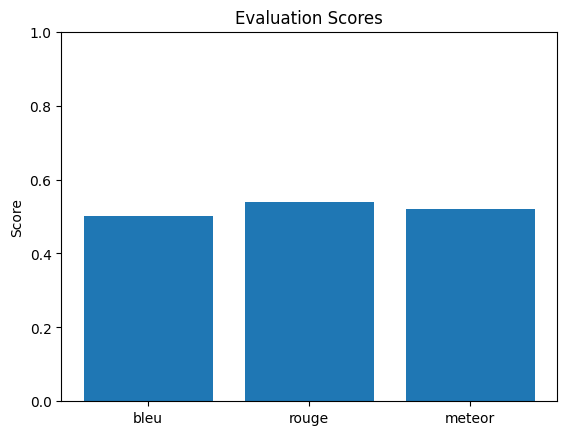

In [1]:
import matplotlib.pyplot as plt

metrics = {"bleu": 0.50, "rouge": 0.54, "meteor": 0.52}

plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Evaluation Scores")
plt.ylabel("Score")
plt.show()
